<h1> Imports e installs <h1>

In [100]:
!pip install db-sqlite3
!pip install flask-ngrok
import base64
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from datetime import date
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import numpy as np
from PIL import Image, ImageFilter
import os
from flask_ngrok import run_with_ngrok
from flask import Flask,flash, request, redirect, url_for
from werkzeug.utils import secure_filename
from keras.backend import manual_variable_initialization 
import uuid
import base64
from io import BytesIO

# Se voce quiser ver a NN treinando, mude a variável abaixo pra True. Deve demorar alguns minutos.

In [112]:
demonstrate_training=False

In [113]:
if (demonstrate_training==True):
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  image_index = 7777 # You may select anything up to 60,000
  
  x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
  x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
  input_shape = (28, 28, 1)
  # Check se ta em float
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  # Normaliza pra 255
  x_train /= 255
  x_test /= 255
  print('x_train shape:', x_train.shape)
  print('Number of images in x_train', x_train.shape[0])
  print('Number of images in x_test', x_test.shape[0])

  # Cria nossa NN
  model = Sequential()
  model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten()) 
  model.add(Dense(128, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(10,activation=tf.nn.softmax))
  model.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
  
  #Fit na NN
  model.fit(x=x_train,y=y_train, epochs=10)
  #Eval
  model.evaluate(x_test, y_test)
  image_index = 4444
  plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
  pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
  print(pred.argmax())
  #Salva o modelo para não termos que treinar toda vez que alguem quiser usar o código
  model.save('my_model.h5')

manual_variable_initialization(True)
new_model = tf.keras.models.load_model('my_model.h5')
# Resumo da NN
new_model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 28)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4732)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               605824    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 607,394
Trainable params: 607,394
Non-trainable params: 0
__________________________________________________

Rode de a célula abaixo para testar alguns valores

28
4


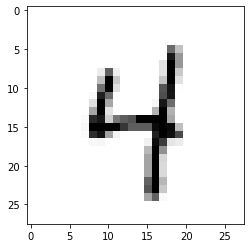

In [103]:
print(len(x_test[1]))
image_index = np.random.randint(0,len(x_test[1]))
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = new_model.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())

<h1> UTILITY FUNCTIONS

In [104]:
#função pra tratar e preparar as imagens que são recebidas
def imageprepare(argv):
   
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255))  

    if width > height:  # check which dimension is bigger
        # Width is bigger. Width becomes 20 pixels.
        nheight = int(round((20.0 / width * height), 0))  # resize height according to ratio width
        if (nheight == 0):  # rare case but minimum is 1 pixel
            nheight = 1
            # resize and sharpen
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))  # calculate horizontal position
        newImage.paste(img, (4, wtop))  # paste resized image on white canvas
    else:
        # Height is bigger. Heigth becomes 20 pixels.
        nwidth = int(round((20.0 / height * width), 0))  # resize width according to ratio height
        if (nwidth == 0):  # rare case but minimum is 1 pixel
            nwidth = 1
            # resize and sharpen
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))  # caculate vertical pozition
        newImage.paste(img, (wleft, 4))  # paste resized image on white canvas

    # newImage.save("sample.png

    tv = list(newImage.getdata())  # get pixel values

    # normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [(255 - x) * 1.0 / 255.0 for x in tv]
    print(tva)
    return tva

def decode_and_save(path):
  #split o path pra pegar só o nome sem .txt
  filename=path.rsplit('.', 1)[0]
  #abre o txt 
  f = open(path, 'r')
  #le e armazena
  data = f.read()
  #fecha o arquivo
  f.closed
  #decodifica o base64 numa imagem
  im = Image.open(BytesIO(base64.b64decode(data)))
  #save em .png
  im.save(filename+'.png', 'PNG')
  #retorna o path
  return filename+'.png'

Definição do API

In [117]:
UPLOAD_FOLDER = ''
#garante que só aceita .txt
ALLOWED_EXTENSIONS = {'txt'}
app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
run_with_ngrok(app)   #starts ngrok when the app is run
 #escolhi rodar com o negrok pra conseguir rodar via google collab, assim se alguem quiser executar o código sem ter jupyter ou algo do tipo, consegue
def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS
#definição da API
@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        # checka se a chamada tem file
        if 'file' not in request.files:
            flash('No file part')
            return redirect(request.url)
        file = request.files['file']
        # if user does not select file, browser also
        # submit an empty part without filename
        if file.filename == '':
            flash('No selected file')
            return redirect(request.url)
        if file and allowed_file(file.filename):
            filename = secure_filename(file.filename)
            file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename))
            #trata o arquivo e passa path do png
            img = imageprepare(decode_and_save(filename))
            
            img = np.array(img)
            img = img.reshape(1,28,28,1)
            pred= new_model.predict(img)
            #connecta da db e insere a chamada
            db = sqlite3.connect("testing.db")
            Path=filename
            Result=str(pred.argmax())
            Id=uuid.uuid4()
            Date=date.today().strftime("%d-%m-%Y")
            cmd = "insert into results(Id,Date,Path,Result) values('{}','{}','{}','{}')".format(Id,Date,Path,Result)
            db.execute(cmd)
            db.commit()
            db.close()
            #retorna o valor predito
            return Result
    return '''
    <!doctype html>
    <title>Number Guesser</title>
    <h1>Envie seu arquivo .txt contendo o base64</h1>
    <form method=post enctype=multipart/form-data>
      <input type=file name=file>
      <input type=submit value=Upload>
    </form>
    '''

# Criação do db

In [115]:
#connecting with the database.
db = sqlite3.connect("testing.db")
db.execute("drop table if exists results")
try:
  db.execute("create table results(Id text,Date datetime,Path text,Result text)")
except:
  print("Already table existed !!")

In [118]:
#roda e disponibiliza a api
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://fd440109e4f4.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [10/Oct/2020 17:29:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Oct/2020 17:29:19] "GET /favicon.ico HTTP/1.1" 404 -


pause o run do servidor na célula acima caso você queira ver o db, e rode a célula abaixo

In [108]:
db = sqlite3.connect("testing.db")
qry = """

SELECT * FROM results

"""
df = pd.read_sql_query(qry, db)
df.head()

,Id,Date,Path,Result
0,aee6bfe9-dc93-4c5c-bbfc-b11b2dec041f,10-10-2020,image1.txt,2
